In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L2
import warnings
warnings.filterwarnings('ignore')

2023-11-11 20:52:23.677607: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 20:52:23.815948: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 20:52:23.815976: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 20:52:23.816837: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 20:52:23.892105: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 20:52:23.894112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
train_path = 'data/cats-dogs/train'
len(os.listdir(train_path))

25000

### Visualization Some pictures

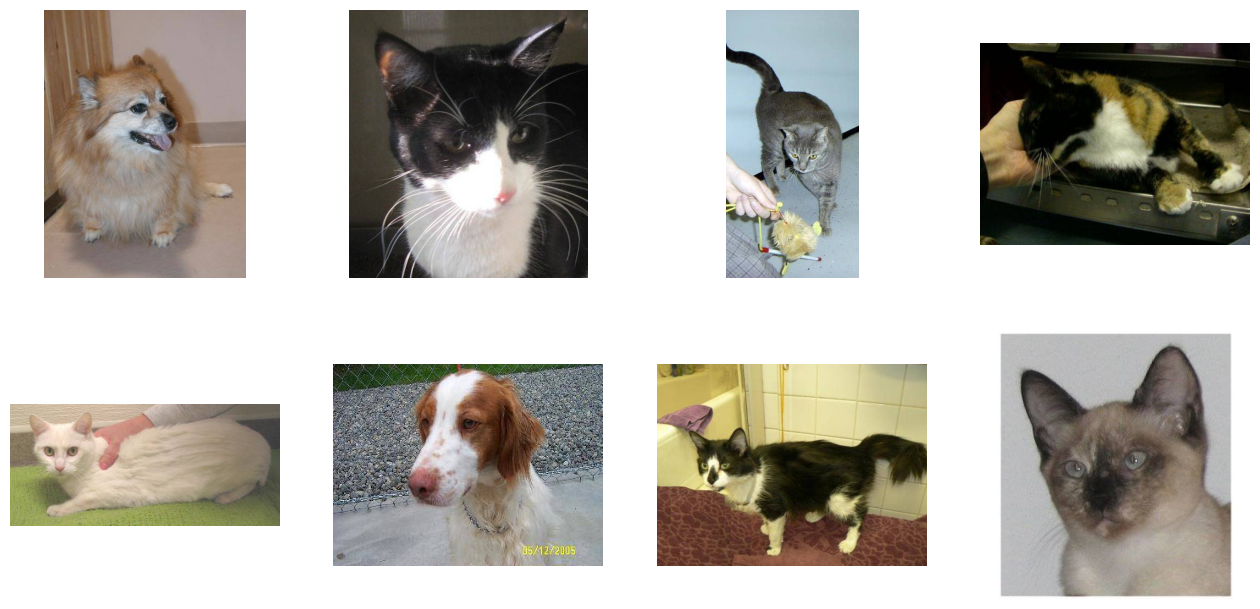

In [3]:
plt.figure(figsize=(16,16))
images = os.listdir(train_path)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(train_path, img)) 
    fig.imshow(img) 

In [6]:
os.listdir(train_path)[:20]

['dog.8659.jpg',
 'cat.4935.jpg',
 'cat.9291.jpg',
 'cat.10060.jpg',
 'dog.4013.jpg',
 'cat.140.jpg',
 'dog.4214.jpg',
 'dog.1732.jpg',
 'dog.2490.jpg',
 'dog.40.jpg',
 'dog.7974.jpg',
 'dog.2496.jpg',
 'cat.9960.jpg',
 'cat.2204.jpg',
 'cat.11976.jpg',
 'dog.2123.jpg',
 'dog.2865.jpg',
 'dog.9573.jpg',
 'cat.7511.jpg',
 'dog.5059.jpg']

### Organize the directories

In [8]:
# for dir in ['training', 'validation']:
#     path = os.path.join('data/cats-dogs' , dir)
#     os.mkdir(path)
#     for dir in ['cats', 'dogs']:
#         n_path = os.path.join(path , dir)
#         os.mkdir(n_path)

In [9]:
src_dir = train_path
cats_train_dir = 'data/cats-dogs/training/cats'
cats_valid_dir = 'data/cats-dogs/validation/cats'
dogs_train_dir = 'data/cats-dogs/training/dogs'
dogs_valid_dir = 'data/cats-dogs/validation/dogs'

cats = [img for img in os.listdir(src_dir) if img[:3] == 'cat']
dogs = [img for img in os.listdir(src_dir) if img[:3] == 'dog']

In [10]:
# Take 10% of training images for validation    
np.random.seed(100)
cats_valid_sample = random.sample(cats, int(0.1*len(cats))) 
dogs_valid_sample = random.sample(dogs, int(0.1*len(dogs)))

In [11]:
for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)
    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)
    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)
    if not os.path.exists(dest_img):
        shutil.copyfile(src_img, dest_img)

In [12]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  12370
No. of cats for validation:  2370

No. of ALL dogs :  12500
No. of dogs for training:  12369
No. of dogs for validation:  2369


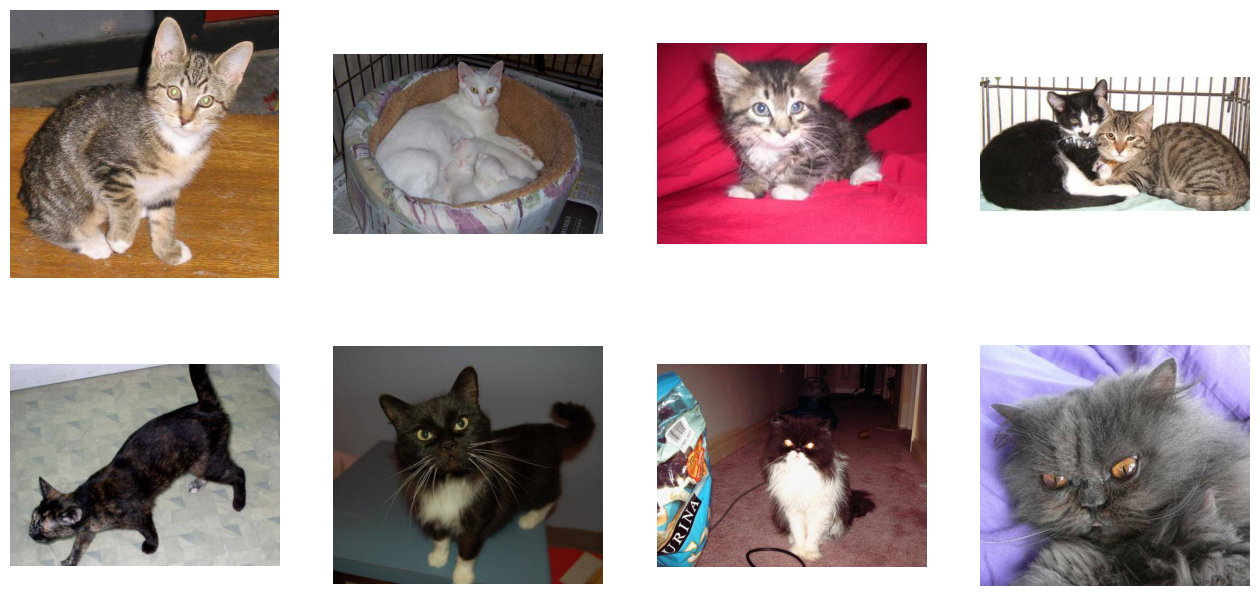

In [13]:
plt.figure(figsize=(16,16))

images = os.listdir(cats_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(cats_train_dir, img)) 
    fig.imshow(img) 

### Image Data Generator

In [14]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

In [15]:
train_dir = 'data/cats-dogs/training/'
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
valid_dir = 'data/cats-dogs/validation/'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 24739 images belonging to 2 classes.
Found 4739 images belonging to 2 classes.


In [16]:
print(valid_generator.class_indices)

{'cats': 0, 'dogs': 1}


### Modelling

In [17]:
# create model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

2023-11-11 20:53:15.771225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 20:53:15.868809: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
# Compile model 
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [19]:
# fit the model 
history = model.fit(train_generator, epochs=5, verbose=1, validation_data=valid_generator)

Epoch 1/5


2023-11-11 20:53:17.791024: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 89718784 exceeds 10% of free system memory.
2023-11-11 20:53:17.825958: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22429696 exceeds 10% of free system memory.
2023-11-11 20:53:17.834198: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42467328 exceeds 10% of free system memory.
2023-11-11 20:53:17.898291: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23970816 exceeds 10% of free system memory.
2023-11-11 20:53:17.898391: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23970816 exceeds 10% of free system memory.


774/774 [==============================] - 228s 294ms/step - loss: 0.5938 - accuracy: 0.6710 - val_loss: 0.4843 - val_accuracy: 0.7715
Epoch 2/5
774/774 [==============================] - 226s 292ms/step - loss: 0.4658 - accuracy: 0.7770 - val_loss: 0.3927 - val_accuracy: 0.8234
Epoch 3/5
774/774 [==============================] - 249s 321ms/step - loss: 0.3988 - accuracy: 0.8202 - val_loss: 0.3584 - val_accuracy: 0.8350
Epoch 4/5
774/774 [==============================] - 239s 308ms/step - loss: 0.3485 - accuracy: 0.8433 - val_loss: 0.2978 - val_accuracy: 0.8768
Epoch 5/5
774/774 [==============================] - 240s 310ms/step - loss: 0.2951 - accuracy: 0.8749 - val_loss: 0.2297 - val_accuracy: 0.9093


<Axes: >

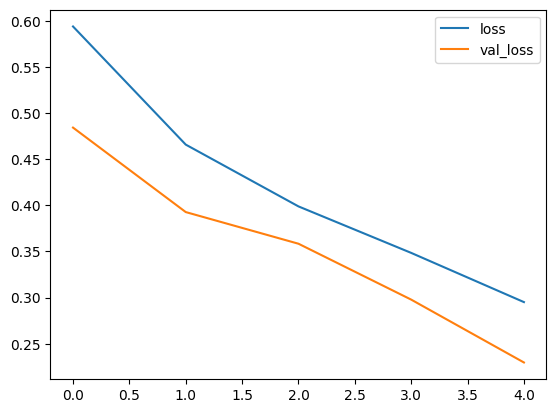

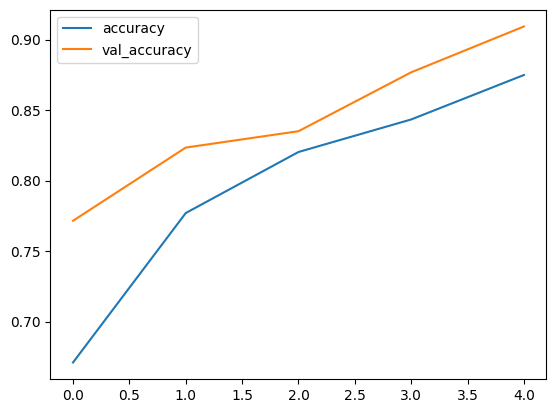

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [21]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Our Base Model Accuracy on Training Data: ", train_acc)
print("Our Base Model Accuracy on Validation Data: ", valid_acc)

149/149 [==============================] - 9s 62ms/step - loss: 0.2297 - accuracy: 0.9093
Our Base Model Accuracy on Training Data:  0.911677896976471
Our Base Model Accuracy on Validation Data:  0.909263551235199


***Data Augmentation on the fly***
1. A technique of artificially increasing the training set by creating modified copies of a dataset using existing data.
2. Increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation
3. Enlarge dataset
4. Avoid Overfitting

https://medium.com/@tagxdata/data-augmentation-for-computer-vision-9c9ed474291e

In [35]:
aug_train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1/255)
train_dir = 'data/cats-dogs/training/'
aug_train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
valid_dir = 'data/cats-dogs/validation/'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 24739 images belonging to 2 classes.
Found 4739 images belonging to 2 classes.


**Augmented Model**

In [36]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('data/cats-dogs/weights.best.hdf5', monitor='val_loss', save_best_only=True)]


In [37]:
# create model
aug_model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                        MaxPooling2D(2, 2),
                        Conv2D(64, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Conv2D(128, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(1, activation='sigmoid')
                       ])

# load weights if exists
if os.path.exists("data/cats-dogs/weights.best.hdf5"):
    aug_model.load_weights("weights.best.hdf5")

# Compile model 
aug_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
aug_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 17, 17, 128)      

In [38]:
aug_history = aug_model.fit(aug_train_generator, epochs=5, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/5
774/774 [==============================] - 223s 287ms/step - loss: 0.5624 - accuracy: 0.6994 - val_loss: 0.4621 - val_accuracy: 0.7867
Epoch 2/5
774/774 [==============================] - 223s 288ms/step - loss: 0.4453 - accuracy: 0.7892 - val_loss: 0.3815 - val_accuracy: 0.8282
Epoch 3/5
774/774 [==============================] - 224s 289ms/step - loss: 0.3795 - accuracy: 0.8310 - val_loss: 0.3164 - val_accuracy: 0.8668
Epoch 4/5
774/774 [==============================] - 228s 294ms/step - loss: 0.3253 - accuracy: 0.8581 - val_loss: 0.2602 - val_accuracy: 0.8924
Epoch 5/5
774/774 [==============================] - 240s 311ms/step - loss: 0.2792 - accuracy: 0.8822 - val_loss: 0.2438 - val_accuracy: 0.8989


<Axes: >

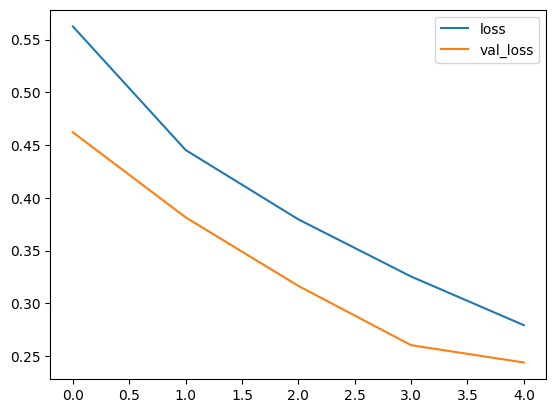

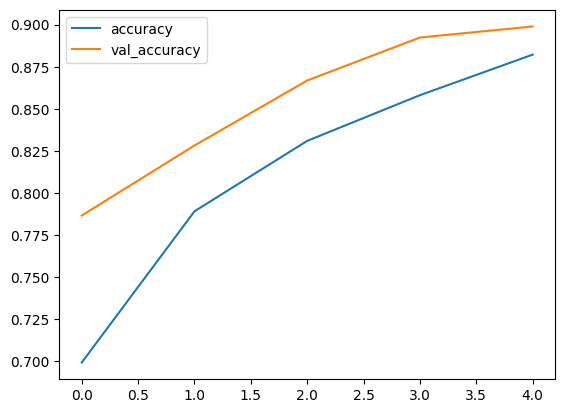

In [41]:
history_df = pd.DataFrame(aug_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [42]:
train_acc = aug_model.evaluate(train_generator)[1]
valid_acc = aug_model.evaluate(valid_generator)[1]
print("Our Augmented Base Model Accuracy on Training Data: ", train_acc)
print("Our Augmented Base Model Accuracy on Validation Data: ", valid_acc)

149/149 [==============================] - 9s 58ms/step - loss: 0.2438 - accuracy: 0.8989
Our Augmented Base Model Accuracy on Training Data:  0.8982577919960022
Our Augmented Base Model Accuracy on Validation Data:  0.8989238142967224
